In [11]:
#Importing Necessary Libraries
import tensorflow as tf
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import ssl
import certifi
ssl._create_default_https_context = ssl._create_unverified_context

print(tf.__version__)

2.20.0


In [12]:
#PHASE 1: DATA LOADING AND PREPROCESSING

def load_face_dataset(dataset_path, img_size=(128, 128), test_size=0.2, random_state=42):    
    print(f"📂 Loading dataset from: {dataset_path}\n")

    images = []
    labels = []
    class_names = []
    
    # Get all person folders (subdirectories)
    person_folders = sorted([f for f in os.listdir(dataset_path) 
                            if os.path.isdir(os.path.join(dataset_path, f))])
    
    if len(person_folders) == 0:
        raise ValueError(f"❌ No subfolders found in {dataset_path}!\n")
    
    print(f"👥 Found {len(person_folders)} people: {person_folders}\n")
    
    # Iterate through each person's folder
    for label_idx, person_name in enumerate(person_folders):
        class_names.append(person_name)
        person_folder = os.path.join(dataset_path, person_name)
        
        # Get all image files
        image_files = [f for f in os.listdir(person_folder) 
                      if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        
        print(f"Loading {person_name}: {len(image_files)} images found")
        
        for img_file in image_files:
            img_path = os.path.join(person_folder, img_file)
            
            try:
                # Method 1: Try PIL (works for real JPG/PNG)
                img = Image.open(img_path)
                img.load()  # Force load to catch errors early
                img = img.convert('RGB')
                
            except Exception as inaccessible:
                # File is completely unreadable - skip it
                print(f"      ❌ SKIPPED {img_file}: Corrupted or invalid file")
                continue
            
            try:
                # Resize to uniform dimensions
                img = img.resize(img_size)
                
                # Convert to numpy array
                img_array = np.array(img)
                
                images.append(img_array)
                labels.append(label_idx)
                
            except Exception as e:
                print(f"      ⚠️  Error processing {img_file}: {e}")
                continue
    
    # Convert lists to numpy arrays
    images = np.array(images, dtype=np.float32)
    labels = np.array(labels, dtype=np.int32)
    
    # Check if we actually loaded any images
    if len(images) == 0:
        raise ValueError("❌ No images were successfully loaded! Check your files.")
    
    # Normalize pixel values to 0-1 range (like MNIST!)
    images = images / 255.0
    
    print(f"\n✅ Successfully loaded {len(images)} total images")
    print(f"   Image shape: {images.shape}")
    print(f"   Labels: {class_names}")
    print(f"   Distribution: {dict(zip(class_names, np.bincount(labels)))}")
    
    # Only split if we have enough images
    if len(images) < 5:
        print("\n⚠️  Warning: Very few images! Using all as training data.")
        return (images, labels), (np.array([]), np.array([])), class_names
    
    # Split into train and test sets
    try:
        x_train, x_test, y_train, y_test = train_test_split(
            images, labels, 
            test_size=test_size, 
            random_state=random_state,
            stratify=labels  # Ensures balanced split
        )
    except ValueError:
        # If stratify fails (too few samples per class), split without it
        print("   ⚠️  Not enough samples per person for stratified split")
        x_train, x_test, y_train, y_test = train_test_split(
            images, labels, 
            test_size=test_size, 
            random_state=random_state
        )
    
    print(f"\n📊 Dataset split:")
    print(f"   Training: {len(x_train)} images")
    print(f"   Testing: {len(x_test)} images")
    
    return (x_train, y_train), (x_test, y_test), class_names

In [13]:
def show_sample_images(x_data, y_data, class_names, num_samples=7):
    plt.figure(figsize=(15, 3))
    for i in range(min(num_samples, len(x_data))):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(x_data[i])
        plt.title(f"{class_names[y_data[i]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [14]:
#PHASE 2: BUILDING, COMPILING, AND TRAINING THE MODEL

def build_small_cnn_for_small_data(input_shape=(128, 128, 3), num_classes=8):
   
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        
        # Block 1 - Keep it simple
        layers.Conv2D(16, (3, 3), padding='same', activation='relu'),  # Fewer filters
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),
        
        # Block 2 - Additional Conv Layer
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        # Block 2 - Another Conv Layer
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),
        
        # Classification Layer
        layers.Flatten(),
        layers.Dense(64, activation='relu'),  # Smaller dense layer
        layers.Dropout(0.5),
        
        layers.Dense(num_classes, activation='softmax')
    ])
    return model


In [15]:
def compileModel(model):
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),  # Higher LR
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return

In [16]:
def earlyStopper():
    early_stop = keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        mode='max',
        verbose=1
    )   
    return early_stop

In [17]:
def trainModel(model, x_train, y_train, early_stop):
    history = model.fit(
        x_train, y_train,
        epochs=40,
        batch_size=16,
        validation_split=0.2,
        callbacks=[early_stop],
        verbose=2
    )
    return history

In [18]:
#PHASE 3: EVALUATION AND VISUALIZATION

def plot_training_history(history):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Accuracy
    ax1.plot(history.history['accuracy'], label='Training', linewidth=2)
    ax1.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
    ax1.set_title('Model Accuracy', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Loss
    ax2.plot(history.history['loss'], label='Training', linewidth=2)
    ax2.plot(history.history['val_loss'], label='Validation', linewidth=2)
    ax2.set_title('Model Loss', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print best scores
    best_val_acc = max(history.history['val_accuracy'])
    best_epoch = history.history['val_accuracy'].index(best_val_acc) + 1
    print(f"\n📊 Best validation accuracy: {best_val_acc*100:.2f}% at epoch {best_epoch}")


In [19]:
def evaluate_model(model, x_test, y_test, class_names):
    
    print("\n" + "="*60)
    print("📊 MODEL EVALUATION")
    print("="*60)
    
    # Overall metrics
    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
    print(f"\n✅ Overall Test Accuracy: {test_accuracy*100:.2f}%")
    print(f"   Test Loss: {test_loss:.4f}")
    
    # Per-class accuracy
    predictions = model.predict(x_test, verbose=0)
    predicted_classes = np.argmax(predictions, axis=1)
    
    print(f"\n📈 Per-Person Accuracy:")
    for i, person in enumerate(class_names):
        mask = y_test == i
        if mask.sum() > 0:
            person_acc = (predicted_classes[mask] == i).mean()
            print(f"   {person:12s}: {person_acc*100:5.1f}% ({mask.sum()} images)")
    
    # Show predictions with confidence and display the image
    sample_count = 30  # show up to this many samples
    print(f"\n🔮 Sample Predictions (first {sample_count}):")
    for i in range(min(sample_count, len(x_test))):
        pred_class = predicted_classes[i]
        actual_class = y_test[i]
        confidence = predictions[i][pred_class] * 100
        
        status = "✅" if pred_class == actual_class else "❌"
        print(f"   {status} Predicted: {class_names[pred_class]:12s} "
              f"({confidence:4.1f}% confident) | Actual: {class_names[actual_class]}")
    return test_accuracy


📂 Loading dataset from: Friend_Images

👥 Found 8 people: ['Alexa', 'Emman', 'Enzo', 'Joshua', 'Migy', 'Rafiq', 'Vaun', 'Zoe']

Loading Alexa: 40 images found
Loading Emman: 40 images found
Loading Enzo: 40 images found
Loading Joshua: 40 images found
Loading Migy: 40 images found
Loading Rafiq: 40 images found
Loading Vaun: 40 images found
Loading Zoe: 40 images found

✅ Successfully loaded 320 total images
   Image shape: (320, 128, 128, 3)
   Labels: ['Alexa', 'Emman', 'Enzo', 'Joshua', 'Migy', 'Rafiq', 'Vaun', 'Zoe']
   Distribution: {'Alexa': np.int64(40), 'Emman': np.int64(40), 'Enzo': np.int64(40), 'Joshua': np.int64(40), 'Migy': np.int64(40), 'Rafiq': np.int64(40), 'Vaun': np.int64(40), 'Zoe': np.int64(40)}

📊 Dataset split:
   Training: 256 images
   Testing: 64 images
People: ['Alexa', 'Emman', 'Enzo', 'Joshua', 'Migy', 'Rafiq', 'Vaun', 'Zoe']
Training: 256, Testing: 64

📸 Showing sample training images...


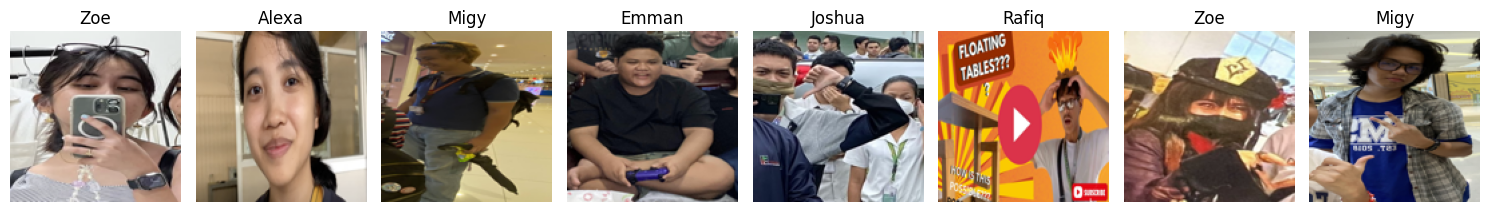

Epoch 1/40
13/13 - 2s - 120ms/step - accuracy: 0.1324 - loss: 2.3006 - val_accuracy: 0.1154 - val_loss: 2.0789
Epoch 2/40
13/13 - 1s - 54ms/step - accuracy: 0.1324 - loss: 2.0774 - val_accuracy: 0.1346 - val_loss: 2.0803
Epoch 3/40
13/13 - 1s - 62ms/step - accuracy: 0.1373 - loss: 2.0777 - val_accuracy: 0.1346 - val_loss: 2.0810
Epoch 4/40
13/13 - 1s - 53ms/step - accuracy: 0.1373 - loss: 2.0788 - val_accuracy: 0.0577 - val_loss: 2.0816
Epoch 5/40
13/13 - 1s - 61ms/step - accuracy: 0.1863 - loss: 2.0752 - val_accuracy: 0.0962 - val_loss: 2.0809
Epoch 6/40
13/13 - 1s - 65ms/step - accuracy: 0.1814 - loss: 2.0669 - val_accuracy: 0.0962 - val_loss: 2.0748
Epoch 7/40
13/13 - 1s - 55ms/step - accuracy: 0.1520 - loss: 2.0587 - val_accuracy: 0.1154 - val_loss: 2.0687
Epoch 8/40
13/13 - 1s - 57ms/step - accuracy: 0.1667 - loss: 2.0308 - val_accuracy: 0.2115 - val_loss: 2.0329
Epoch 9/40
13/13 - 1s - 57ms/step - accuracy: 0.1814 - loss: 2.0174 - val_accuracy: 0.2500 - val_loss: 2.0086
Epoch 10/

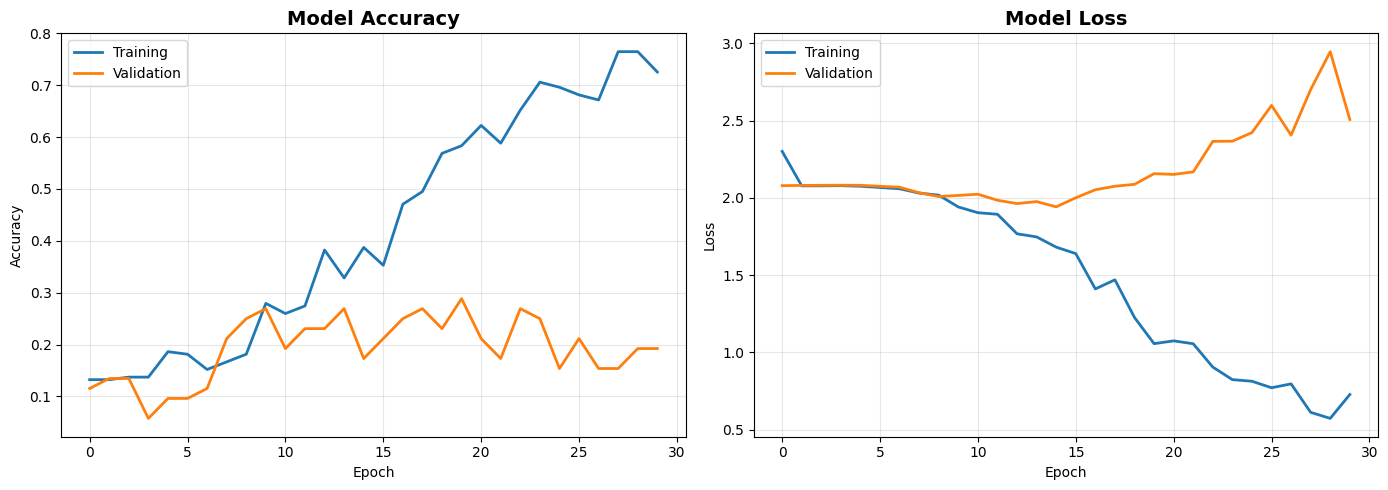


📊 Best validation accuracy: 28.85% at epoch 20

📊 MODEL EVALUATION

✅ Overall Test Accuracy: 23.44%
   Test Loss: 2.6040

📈 Per-Person Accuracy:
   Alexa       :   0.0% (8 images)
   Emman       :  25.0% (8 images)
   Enzo        :  37.5% (8 images)
   Joshua      :  25.0% (8 images)
   Migy        :  25.0% (8 images)
   Rafiq       :  12.5% (8 images)
   Vaun        :  50.0% (8 images)
   Zoe         :  12.5% (8 images)

🔮 Sample Predictions (first 30):
   ✅ Predicted: Vaun         (28.9% confident) | Actual: Vaun
   ❌ Predicted: Zoe          (28.5% confident) | Actual: Rafiq
   ❌ Predicted: Zoe          (22.1% confident) | Actual: Alexa
   ❌ Predicted: Vaun         (31.6% confident) | Actual: Alexa
   ❌ Predicted: Emman        (96.9% confident) | Actual: Joshua
   ❌ Predicted: Emman        (45.7% confident) | Actual: Joshua
   ❌ Predicted: Emman        (35.0% confident) | Actual: Migy
   ✅ Predicted: Migy         (71.4% confident) | Actual: Migy
   ❌ Predicted: Vaun         (28.4% c

In [20]:
#PHASE 4: FULL PIPELINE IMPLEMENTATION

# 1. Load data
(x_train, y_train), (x_test, y_test), class_names = load_face_dataset("Friend_Images")
print(f"People: {class_names}")
print(f"Training: {len(x_train)}, Testing: {len(x_test)}")

# Display some sample images
print("\n📸 Showing sample training images...")
show_sample_images(x_train, y_train, class_names, num_samples=8)

# 2. Use the ORIGINAL simple CNN (the one that worked!)
model = build_small_cnn_for_small_data(num_classes=len(class_names))

# 3. Compile with good settings
compileModel(model)

# 4. Simple callbacks
early_stop = earlyStopper()

# 5. MINIMAL augmentation (or none to start)
minimal_aug = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=3
)

# 6. Train the model
history = trainModel(model, x_train, y_train, early_stop)

# 7. Check results
plot_training_history(history)
evaluate_model(model, x_test, y_test, class_names)

# 8. Save the model
model.save('Models/friend_classifier.keras')
print("\n💾 Model saved as 'friend_classifier.keras'")